In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.complexity import gap_complexity

In [2]:
sullivan = False

if sullivan:
    
    filename='cgap-sullivan.png'
    
    with open("filtered_data.pkl", "rb") as f:
         data = pickle.load(f)
        
        
    close = data["close"]
    good = data["good"]
    db_filtered = data["db_filtered"]
    kois_filtered = data["kois_filtered"]
    kois_good = data["kois_good"]
    cks_filtered = data["cks_filtered"]
    cks_good = data["cks_good"]

else:
    
    filename='cgap-allbin.png'

    with open('tables/kois+gaia.pkl', 'rb') as file:
            kois = pd.read_pickle(file)

            
    # BINARIES -- data
    
    # confirmed planets only
    allbin = Table.read('tables/plan_allbinall.mrt', format='ascii.mrt').to_pandas()

    mask = allbin['Alternate'].str.match(r'^KOI\d+(?:\.\d+)?$', na=False)
    tmp = allbin.loc[mask].copy()
    tmp['KOI'] = tmp['Alternate'].str.extract(r'KOI0*(\d+)', expand=False).astype(int)
    
    # stars with at least one confirmed KOI
    db=tmp.merge(kois, on='KOI', suffixes=['','_y'])
    db_filtered = db[(db['koi_disposition'] != 'FALSE POSITIVE') & (db['koi_period']<100)].copy()
    
    close = db_filtered['semi-major']<100


    # CKS

    tmp = Table.read('tables/fulton2018.vot').to_pandas()
    tmp['kepoi_name'] = tmp['KOI']
    tmp['KOI'] = tmp['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)
    cks=tmp.merge(kois, on='kepoi_name', suffixes=['','_y'])

    # basic filtering 
    quality_mask = (
        (~cks['KOI'].isin(db['KOI'])) &
        (cks['koi_disposition'] != 'FALSE POSITIVE') &
        np.isfinite(cks['parallax']) &
        (cks['ruwe'] < 1.4) &
        (cks['koi_kepmag'] < 14.2) & 
        (cks['koi_period']<100)
    )

    # at least one CONFIRMED per KOI 
    has_confirmed = (
        cks.groupby('KOI')['koi_disposition']
        .transform(lambda s: (s == 'CONFIRMED').any())
    )

    # combine both masks 
    cks_filtered = cks[quality_mask & has_confirmed]

    
    # KOIS

    # basic filtering 
    quality_mask = (
        (~kois['KOI'].isin(db['KOI'])) &
        (kois['koi_disposition'] != 'FALSE POSITIVE') &
        np.isfinite(kois['parallax']) &
        (kois['ruwe'] < 1.4)  & 
        (kois['koi_period']<100)  )

    # at least one CONFIRMED per KOI 
    has_confirmed = (
        kois.groupby('KOI')['koi_disposition']
        .transform(lambda s: (s == 'CONFIRMED').any())
    )

    # combine both masks 
    kois_filtered = kois[quality_mask & has_confirmed]





In [3]:
complexity_df = (db_filtered[~close]
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: db_filtered[~close].groupby('KOI').size().values)
            )

closeb_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

complexity_df = (db_filtered[close]
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: db_filtered[close].groupby('KOI').size().values)
            )

wideb_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values


complexity_df = (kois_filtered
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: kois_filtered.groupby('KOI').size().values)
            )

kois_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

complexity_df = (cks_filtered
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: cks_filtered.groupby('KOI').size().values)
            )

cks_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

/Users/ernewton/Research/HWO_calculations/sbin/complexity.py:63: RuntimeWarning: divide by zero encountered in log
  entropy = np.sum(p_star * np.log(p_star))
/Users/ernewton/Research/HWO_calculations/sbin/complexity.py:63: RuntimeWarning: invalid value encountered in multiply
  entropy = np.sum(p_star * np.log(p_star))


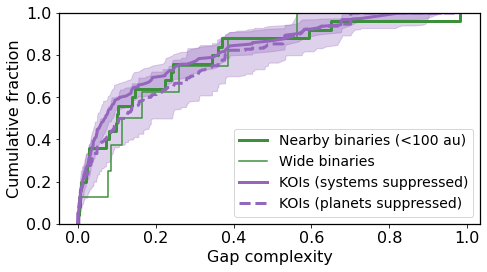

In [6]:
import seaborn as sns

if sullivan:
    cc = '#1f77b4'
else:
    cc = '#3c903c'
    
fig, ax = plt.subplots(figsize=(7, 4))
sns.ecdfplot(closeb_complexity, ax=ax,
             label='Nearby binaries (<100 au)', linewidth=3, color=cc)
sns.ecdfplot(wideb_complexity, ax=ax,
             label='Wide binaries', color=cc)

x_grid, lower, median, upper = pickle.load(open('kois_complexity_moekratter_systems.pkl','rb'))
ax.fill_between(x_grid, lower, upper, color='C4', alpha=0.3)
ax.plot(x_grid, median, color='C4', linewidth=3,
        label='KOIs (systems suppressed)')
#sns.ecdfplot(kois_complexity, ax=ax,
#             label='KOIs (observed)',      color='C4', linewidth=2, linestyle='-')

x_grid, lower, median, upper = pickle.load(open('kois_complexity_moekratter_planets.pkl','rb'))
ax.fill_between(x_grid, lower, upper, color='C4', alpha=0.3)
ax.plot(x_grid, median, color='C4', linewidth=3, linestyle='--',
        label='KOIs (planets suppressed)')

#sns.ecdfplot(cks_complexity, ax=ax,
#             label='CKS',      color='C1', linewidth=2, linestyle='--')
ax.set_xlabel('Gap complexity')
ax.set_ylabel('Cumulative fraction')
ax.legend()

plt.tight_layout()
if sullivan:
    plt.savefig('complexity_sullivan.png')
else:
    plt.savefig('complexity_tb-build3.png')



In [5]:
from scipy import stats

ks_statistic, p_value = stats.ks_2samp(cks_complexity, closeb_complexity)
print(f"CKS KS statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

ks_statistic, p_value = stats.ks_2samp(wideb_complexity, kois_complexity)
print(f"KOIs KS statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")



CKS KS statistic: 0.2628
p-value: 0.7665
KOIs KS statistic: 0.5177
p-value: 0.1000
